In [1]:
import deeptriplet
import time
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data

import deeptriplet.models.deeplabv3p
from deeptriplet.models.deeplabv3p import DeepLabSpatialEarly

In [2]:
model = DeepLabSpatialLate(backbone='resnet', output_stride=16, dynamic_coordinates=False)
model.eval().cuda()
input = torch.rand(1, 3, 513, 513).cuda()
output = model(input)
print(output.size())

torch.Size([1, 21, 513, 513])


In [3]:
# without benchmarking option
torch.backends.cudnn.benchmark = False
torch.cuda.synchronize()
t1 = time.time()
model(input)
torch.cuda.synchronize()
t2 = time.time()
print(t2 - t1)

0.25795841217041016


In [5]:
# with benchmarking option
torch.backends.cudnn.benchmark = True
torch.cuda.synchronize()
t1 = time.time()
model(input)
torch.cuda.synchronize()
t2 = time.time()
print(t2 - t1)

0.05181002616882324


In [ ]:
d = torch.load("/srv/glusterfs/yardima/runs/pretrained-models/deeplab-resnet-v3-plus.pth")
del d['state_dict']['decoder.last_conv.8.weight']
del d['state_dict']['decoder.last_conv.8.bias']
model.load_state_dict(d['state_dict'], strict=True)

In [33]:

class DecoderSpatialEarly(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm, dynamic=False, size=(129, 129)):
        super(DecoderSpatialEarly, self).__init__()
        if backbone == 'resnet' or backbone == 'drn':
            low_level_inplanes = 256
        elif backbone == 'xception':
            low_level_inplanes = 128
        elif backbone == 'mobilenet':
            low_level_inplanes = 24
        else:
            raise NotImplementedError
            
        self.size = size
        self.dynamic = dynamic

        self.conv1 = nn.Conv2d(low_level_inplanes, 48, 1, bias=False)
        self.bn1 = BatchNorm(48)
        self.relu = nn.ReLU()
        
        # 304 -> 306 for two additional spatial channels
        self.last_conv = nn.Sequential(nn.Conv2d(306, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        
        x = np.linspace(-1., 1., self.size[1], dtype=np.float32)
        y = np.linspace(-1., 1., self.size[0], dtype=np.float32)
        xx, yy = np.meshgrid(x, y)

        spatial_channels = np.append(np.expand_dims(xx,axis=0), np.expand_dims(yy,axis=0), axis=0)
        spatial_channels = np.expand_dims(spatial_channels, axis=0)

        self.spatial_channels = torch.tensor(spatial_channels, device='cuda:0')
    
        self._init_weight()


    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)

        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True)

        x = torch.cat((x, low_level_feat), dim=1)
        
        if self.dynamic:
            batch_size = x.shape[0]
            
            xc = np.linspace(-x.shape[3] / 129., x.shape[3] / 129., x.shape[3], dtype=np.float32)
            yc = np.linspace(-x.shape[2] / 129., x.shape[2] / 129., x.shape[2], dtype=np.float32)
            xx, yy = np.meshgrid(xc, yc)

            spatial_channels = np.append(np.expand_dims(xx,axis=0), np.expand_dims(yy,axis=0), axis=0)
            spatial_channels = np.expand_dims(spatial_channels, axis=0)

            self.spatial_channels = torch.tensor(spatial_channels, device='cuda:0')
            
            x = torch.cat((x, self.spatial_channels.expand(batch_size, -1, -1, -1)), dim=1)
        else:
            batch_size = x.shape[0]
            
            x = torch.cat((x, self.spatial_channels.expand(batch_size, -1, -1, -1)), dim=1)
        
        
        x = self.last_conv(x)
        
        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, SynchronizedBatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def build_decoder_spatial_early(num_classes, backbone, BatchNorm, dynamic=False, size=(129, 129)):
    return DecoderSpatialEarly(num_classes, backbone, BatchNorm, dynamic=dynamic, size=size)

In [103]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from modeling.sync_batchnorm.batchnorm import SynchronizedBatchNorm2d
from modeling.aspp import build_aspp
from modeling.backbone import build_backbone

class DeepLabSpatialEarly(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=21,
                 sync_bn=True, freeze_bn=False, dynamic_coordinates=False, spatial_size=(129, 129)):
        super(DeepLabSpatialEarly, self).__init__()
        if backbone == 'drn':
            output_stride = 8

        if sync_bn == True:
            BatchNorm = SynchronizedBatchNorm2d
        else:
            BatchNorm = nn.BatchNorm2d

        self.backbone = build_backbone(backbone, output_stride, BatchNorm)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder_spatial_early(num_classes, backbone, BatchNorm, dynamic=dynamic_coordinates, size=spatial_size)

        if freeze_bn:
            self.freeze_bn()

    def forward(self, input):
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, SynchronizedBatchNorm2d):
                m.eval()
            elif isinstance(m, nn.BatchNorm2d):
                m.eval()

    def get_1x_lr_params(self):
        modules = [self.backbone]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                        or isinstance(m[1], nn.BatchNorm2d):
                    for p in m[1].parameters():
                        if p.requires_grad:
                            yield p

    def get_10x_lr_params(self):
        modules = [self.aspp, self.decoder]
        for i in range(len(modules)):
            for m in modules[i].named_modules():
                if isinstance(m[1], nn.Conv2d) or isinstance(m[1], SynchronizedBatchNorm2d) \
                        or isinstance(m[1], nn.BatchNorm2d):
                    for p in m[1].parameters():
                        if p.requires_grad:
                            yield p
                            
    def init_from_semseg_model(self,d):
        del d['state_dict']['decoder.last_conv.8.weight']
        del d['state_dict']['decoder.last_conv.8.bias']
        d['state_dict']['decoder.last_conv.0.weight'] = torch.cat((d['state_dict']['decoder.last_conv.0.weight'], 
                                                                   torch.Tensor(256,2,3,3).normal_(std=2e-4).cuda()), 
                                                                  dim=1)
        self.load_state_dict(d['state_dict'], strict=False)


if __name__ == "__main__":
    model = DeepLabSpatialEarly(num_classes=32, backbone='resnet', output_stride=16, dynamic_coordinates=True)
    model.eval().cuda()
    input = torch.rand(1, 3, 200, 513).cuda()
    output = model(input)
    print(output.size())




torch.Size([1, 32, 200, 513])


In [104]:
model = DeepLabSpatialEarly(num_classes=32, backbone='resnet', output_stride=16, dynamic_coordinates=True)

<IPython.core.display.Javascript object>


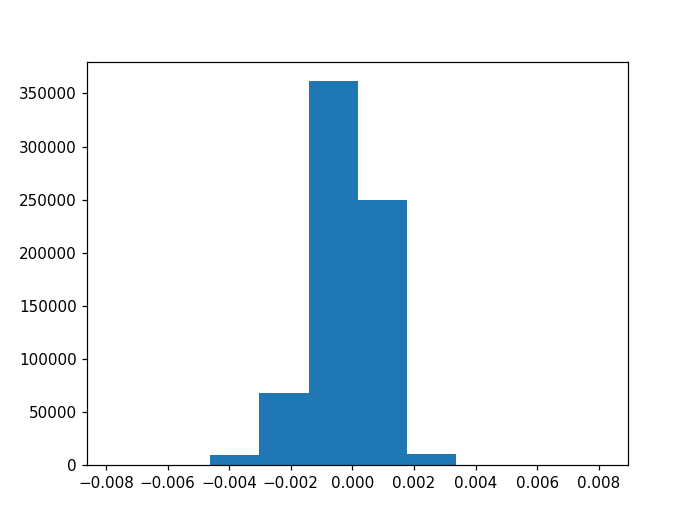

In [66]:
plt.figure()
plt.hist(d['state_dict']['decoder.last_conv.0.weight'].cpu().numpy().ravel());

<IPython.core.display.Javascript object>


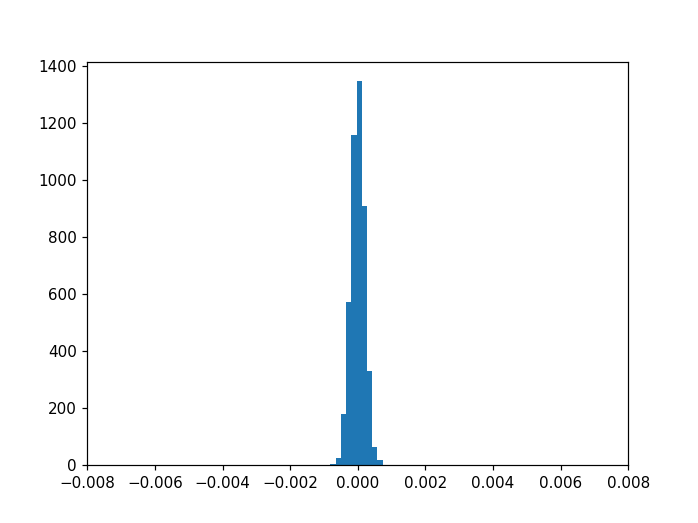

(-0.008, 0.008)

In [99]:
plt.figure()
plt.hist(torch.Tensor(256,2,3,3).normal_(std=2e-4).numpy().ravel())
plt.xlim(-0.008,0.008)

In [106]:
d = torch.load("/scratch-second/yardima/pretrained-models/deeplab-resnet-v3-plus.pth")
# del d['state_dict']['decoder.last_conv.8.weight']
# del d['state_dict']['decoder.last_conv.8.bias']
# d['state_dict']['decoder.last_conv.0.weight'] = torch.cat((d['state_dict']['decoder.last_conv.0.weight'], 
#                                                            torch.Tensor(256,2,3,3).normal_(std=2e-4).cuda()), 
#                                                           dim=1)
# model.load_state_dict(d['state_dict'], strict=False)
model.init_from_semseg_model(d)

# Test library implementation

In [3]:
model = DeepLabSpatialEarly(num_classes=32, backbone='resnet', output_stride=16, dynamic_coordinates=True)

In [4]:
d = torch.load("/scratch-second/yardima/pretrained-models/deeplab-resnet-v3-plus.pth")
model.init_from_semseg_model(d)

In [5]:
model.eval().cuda()
input = torch.rand(1, 3, 200, 513).cuda()
output = model(input)
print(output.size())

torch.Size([1, 32, 200, 513])
